## BERT

Based on findings from LSTM notebook. Small bert with Tensorflow preprocessing & encoding layers used.
As it was trained on Windows, nightly builds were used (look into requirements_bert.txt).

Due to small dataset only two sets are present (train & test, no validation set). Only deduplication copied from LSTM preprocessing.

In [1]:
%load_ext autoreload
%autoreload 2

import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# text must be loaded for hub to work!
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from official.nlp import optimization

np.random.seed(42)

physical_devices = tf.config.list_physical_devices('GPU')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


c:\users\mikol\miniconda3\envs\kaggle02-bert\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210326). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## Loading data

In [2]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [3]:
print(len(train_df))

targets_df = train_df.groupby('text').nunique().sort_values(by='target', ascending=False)
mismatched_texts = list(targets_df[targets_df['target'] > 1].index)

7613


In [4]:
# FIXING duplicates

duplicates_df = train_df[train_df['text'].isin(mismatched_texts) == True]
duplicates_df

,id,keyword,location,text,target
610,881,bioterrorism,NaN,To fight bioterrorism sir.,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1214,1752,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1221,1760,buildings%20burning,dallas,like for the music video I want some real acti...,1
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
1349,1950,burning%20buildings,dallas,like for the music video I want some real acti...,0
1365,1968,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1


In [5]:
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Caution: breathing may be hazardous to your health.', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0

train_df = train_df[train_df['text'].isin(mismatched_texts) == False]
train_df.reset_index(drop=False)
print(len(train_df))
duplicates_df = train_df[train_df['text'].isin(mismatched_texts) == True]
duplicates_df

7558


,id,keyword,location,text,target,target_relabeled


In [5]:
train_df['text'].isnull().values.any()

False

## Data split

In [6]:
X_all = train_df['text']
y_all = train_df['target']

X_all[:3]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
Name: text, dtype: object

In [7]:
X = X_all.to_numpy()
y = y_all.to_numpy()

X[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:3]

array(['Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR',
       '@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears',
       "Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN NOW &amp; RT! https://t.co/u4r8dRiuAc"],
      dtype=object)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset.take(1)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.int64)>

## Building model

In [11]:
preproces_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
preprocessor = hub.KerasLayer(preproces_url, name='preprocessing')

encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
encoder = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')

In [12]:
def build_model(preprocessor, encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')    
    encoder_inputs = preprocessor(text_input)    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

model = build_model(preprocessor, encoder)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 7 109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [17]:
BATCH_SIZE = 32
epochs = 10

def prepare_training_data(train_dataset, test_dataset, epochs):
    train_dataset_batched = train_dataset.shuffle(100).batch(BATCH_SIZE)
    if test_dataset is not None:
        test_dataset_batched = test_dataset.batch(BATCH_SIZE)
    else:
        test_dataset_batched = None

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    
    steps_per_epoch = tf.data.experimental.cardinality(train_dataset_batched).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    
    return train_dataset_batched, test_dataset_batched, optimizer, loss, metrics


train_dataset_batched, test_dataset_batched, optimizer, loss, metrics = prepare_training_data(train_dataset, test_dataset, epochs)

In [16]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model.fit(x=train_dataset_batched,
                    validation_data=test_dataset_batched,
                    epochs=epochs)

Epoch 1/10
189/189 [==============================] - 2101s 11s/step - loss: 0.6001 - binary_accuracy: 0.6510 - val_loss: 0.3780 - val_binary_accuracy: 0.8307
Epoch 2/10
189/189 [==============================] - 2059s 11s/step - loss: 0.4005 - binary_accuracy: 0.8268 - val_loss: 0.3888 - val_binary_accuracy: 0.8459
Epoch 3/10
189/189 [==============================] - 2056s 11s/step - loss: 0.2846 - binary_accuracy: 0.8927 - val_loss: 0.4694 - val_binary_accuracy: 0.8406
Epoch 4/10
189/189 [==============================] - 2055s 11s/step - loss: 0.2068 - binary_accuracy: 0.9315 - val_loss: 0.6213 - val_binary_accuracy: 0.8327
Epoch 5/10
189/189 [==============================] - 2056s 11s/step - loss: 0.1528 - binary_accuracy: 0.9494 - val_loss: 0.7600 - val_binary_accuracy: 0.8194
Epoch 6/10
189/189 [==============================] - 2057s 11s/step - loss: 0.1073 - binary_accuracy: 0.9648 - val_loss: 0.8859 - val_binary_accuracy: 0.8122
Epoch 7/10
189/189 [==========================

48/48 [==============================] - 150s 3s/step - loss: 1.1338 - binary_accuracy: 0.8267
Loss:  1.1337941884994507
Accuracy:  0.8267195820808411


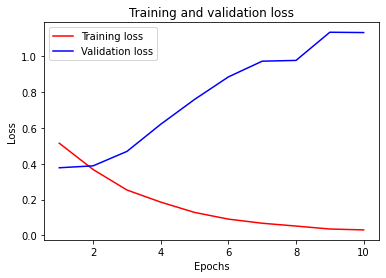

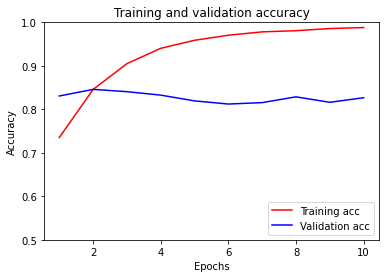

In [17]:
loss, accuracy = model.evaluate(X_test, y_test) # TODO replace
print('Loss: ', loss)
print('Accuracy: ', accuracy)

history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

axes = plt.gca()
axes.set_ylim([0.5, 1])

max_val_acc = f'{np.max(history_dict["val_binary_accuracy"]):.3f}'
mean_val_acc = f'{np.mean(history_dict["val_binary_accuracy"]):.3f}'

# plt.savefig(f'lstm_max{max_val_acc}_mean{mean_val_acc}_embdim{embedding_dim}_lstm{lstm_layer_units}'
#             f'_dense{hidden_layer_units}_drop{dropout_rate}_batch{batch_size}_{iter_count}.png')

plt.show()

In [18]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for test set',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.print(classification_report(y_test, y_pred_test))
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


[[742 125]
 [137 508]]
Normalized confusion matrix


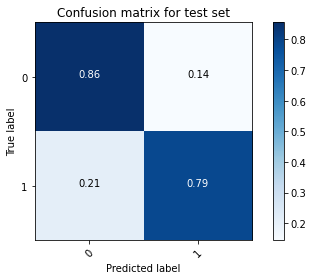

In [19]:
y_pred_test = np.array(model.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm, [0, 1])

In [20]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       867
           1       0.80      0.79      0.79       645

    accuracy                           0.83      1512
   macro avg       0.82      0.82      0.82      1512
weighted avg       0.83      0.83      0.83      1512



## Final model training



In [19]:
final_preprocessor = hub.KerasLayer(preproces_url, name='preprocessing')
final_encoder = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')

X_final = X_all.copy().to_numpy()
y_final = y_all.copy().to_numpy()

final_train_dataset = tf.data.Dataset.from_tensor_slices((X_final, y_final))

train_dataset.take(1)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [20]:
final_epochs = 3

final_train_dataset_batched, final_test_dataset_batched_none, final_optimizer, final_loss, final_metrics = prepare_training_data(final_train_dataset, None, final_epochs)

final_model = build_model(final_preprocessor, final_encoder)

final_model.compile(optimizer=final_optimizer,
              loss=final_loss,
              metrics=final_metrics)

final_history = final_model.fit(x=final_train_dataset_batched, epochs=final_epochs)

Epoch 1/3
238/238 [==============================] - 2518s 10s/step - loss: 0.6630 - binary_accuracy: 0.7086
Epoch 2/3
238/238 [==============================] - 2532s 11s/step - loss: 0.3715 - binary_accuracy: 0.8475
Epoch 3/3
238/238 [==============================] - 2469s 10s/step - loss: 0.2708 - binary_accuracy: 0.8956


238/238 [==============================] - 779s 3s/step - loss: 0.1973 - binary_accuracy: 0.9281
TRAIN LOSS: 0.19734449684619904 / TEST ACCURACY: 0.9281492233276367
[[4185  157]
 [ 390 2881]]
Normalized confusion matrix


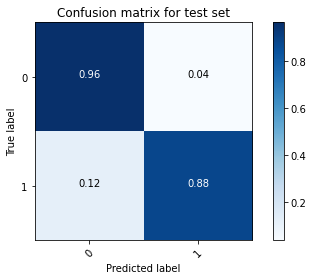

In [27]:
loss_final, accuracy_final = final_model.evaluate(X_final, y_final)
print(f'TRAIN LOSS: {loss_final} / TEST ACCURACY: {accuracy_final}')
y_pred_final = np.array(final_model.predict(X_final) > 0.5).astype('int32')
cm = confusion_matrix(y_final, y_pred_final)
plot_confusion_matrix(cm, [0, 1])

In [30]:
print(classification_report(y_final, y_pred_final))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4342
           1       0.95      0.88      0.91      3271

    accuracy                           0.93      7613
   macro avg       0.93      0.92      0.93      7613
weighted avg       0.93      0.93      0.93      7613



In [32]:
X_out = test_df['text'].to_numpy()
X_out

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [33]:
y_out_pred = np.array(final_model.predict(X_out) > 0.5).astype('int32')
y_out_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [34]:
file = pd.DataFrame({
    'id': test_df['id'],
    'target': [v[0] for v in y_out_pred]
})

file.to_csv('disaster-tweets-bert.csv', index=False)